### Import

In [1]:
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리
from sklearn.preprocessing import LabelEncoder

# Metric
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

### Modeling
import lightgbm as lgbm

## HP Opt.
import optuna

## 데이터 탐색

* Input file: Historical Product Demand.csv 


* Description: CSV data file containing product demand for encoded product id's


* Size of Data: (1048575, 5)


* Features: Product_Code, Warehouse, Product_Category, Date, Order_Demand


* Period: 2011-01-08 ~ 2017-01-09

In [2]:
df = pd.read_csv('Historical Product Demand.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'Historical Product Demand.csv'

In [106]:
# pd.set_option('display.max_columns', 100) ## 모든 열 출력
# pd.set_option('display.max_rows', 100) ## 모든 행 출력

In [87]:
df.shape

(1048575, 5)

In [88]:
df.columns

Index(['Product_Code', 'Warehouse', 'Product_Category', 'Date',
       'Order_Demand'],
      dtype='object')

In [89]:
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [10]:
print("The Number of unique")
print('-----------------------------')
print('Product code:\t', df.Product_Code.nunique())
print('Category:\t', df.Product_Category.nunique())
print('Warehouse:\t', df.Warehouse.nunique())

The Number of unique
-----------------------------
Product code:	 2160
Category:	 33
Warehouse:	 4


### 전처리

In [90]:
df.isna().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [91]:
#NA 값이 1% 미만이므로 이상치라고 판단하여 삭제

df.dropna(axis=0, inplace=True) #remove all rows with na's.
df = df.sort_values('Date').reset_index(drop=True) #Some of the values have () in them.
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0965,Whse_A,Category_006,2011/1/8,2
1,Product_0412,Whse_S,Category_007,2011/10/20,(2)
2,Product_0125,Whse_S,Category_011,2011/10/20,(2)
3,Product_0642,Whse_C,Category_019,2011/10/31,3
4,Product_2137,Whse_S,Category_009,2011/11/18,(25)


In [98]:
#Target Feature - Order_Demand
#Removing () from the target feature.

df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")

#Next step is to change the data type.
df['Order_Demand'] = df['Order_Demand'].astype('int64')

C:\Users\7info\AppData\Local\Temp\ipykernel_27532\1192901098.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
C:\Users\7info\AppData\Local\Temp\ipykernel_27532\1192901098.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")


In [110]:
# 시간 관련 변수 추가

df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].apply(lambda x: x.year)
df['Month'] = df['Date'].apply(lambda x: x.month)
df['Day'] = df['Date'].apply(lambda x: x.day)
df['Weekday'] = df['Date'].apply(lambda x: x.weekday())

In [111]:
df

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Year,Month,Day,Weekday
0,Product_0965,Whse_A,Category_006,2011-01-08,2,2011,1,8,5
1,Product_0412,Whse_S,Category_007,2011-10-20,2,2011,10,20,3
2,Product_0125,Whse_S,Category_011,2011-10-20,2,2011,10,20,3
3,Product_0642,Whse_C,Category_019,2011-10-31,3,2011,10,31,0
4,Product_2137,Whse_S,Category_009,2011-11-18,25,2011,11,18,4
...,...,...,...,...,...,...,...,...,...
1037331,Product_0689,Whse_J,Category_011,2017-01-06,200,2017,1,6,4
1037332,Product_1970,Whse_J,Category_005,2017-01-06,2000,2017,1,6,4
1037333,Product_1904,Whse_C,Category_019,2017-01-09,4000,2017,1,9,0
1037334,Product_0471,Whse_C,Category_015,2017-01-09,30,2017,1,9,0


In [115]:
# 2011 데이터에 결측값이 많이 포함되어, 2012년도부터 데이터 추출

df = df[(df['Date']>='2012-01-01')].reset_index(drop=True)

In [117]:
# 라벨 인코딩

label_encoder = LabelEncoder()
categorical_features = [ 'Product_Code', 'Warehouse', 'Product_Category']

for col in categorical_features:
    df[col] = label_encoder.fit_transform(df[col])

## Baseline Model (LGBM)

### Model Fitting & 파라미터 최적화

In [279]:
def objective(trial):
    params = {
        "metric": "rmse",
        "random_state": 42,
        "learning_rate": trial.suggest_categorical("learning_rate", [0.01, 0.03, 0.05, 0.07, 0.1, 0.2, 0.3]),
        "objective": "regression",
        "learning_rate": 0.01,
        "n_estimators": 500,
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0)
    }
    
    lgbm_gbr = lgbm.LGBMRegressor(**params)
    lgbm_gbr.fit(
        x_train,
        y_train,
        eval_set=(x_valid, y_valid),
        callbacks=[lgbm.early_stopping(stopping_rounds=50)]
    )
    preds = lgbm_gbr.predict(x_valid)
    
    return mean_squared_error(y_valid, preds)**0.5

In [280]:
# Define the helper function so that it can be reused
def tune(objective):
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=10)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    
    return params

In [3]:
df = pd.read_csv("../Data/JW_capstone.csv")
df['Date'] = pd.to_datetime(df['Date'])

### Data Split
* train : valid : test = 0.6 : 0.2 : 0.2 (시간 순서대로 스플릿)

In [5]:
# Data split

train_num = int(len(df)*0.6)
valid_num = int(len(df)*0.8)

x_train = df.loc[:train_num,:].copy()
x_train.drop(['y', 'Date'], axis=1, inplace=True)
y_train = df.loc[:train_num, 'y'].copy()

x_valid = df.loc[train_num:valid_num,:].copy()
x_valid.drop(['y', 'Date'], axis=1, inplace=True)
y_valid = df.loc[train_num:valid_num, 'y'].copy()

x_test = df.loc[valid_num:,:].copy()
x_test.drop(['y', 'Date'], axis=1, inplace=True)
y_test = df.loc[valid_num:, 'y'].copy()

In [7]:
x_train

,Product
0,가나칸정
1,가나칸정
2,가나칸정
3,가나칸정
4,가나칸정
...,...
6690,위너프페리
6691,위너프페리
6692,위너프페리
6693,위너프페리


In [282]:
best_params = tune(objective)

# Model Fitting
model = lgbm.LGBMRegressor(**best_params)

model.fit(x_train, y_train, eval_metric='rmse',
                eval_set=[(x_train, y_train),(x_valid, y_valid)], callbacks=[lgbm.early_stopping(stopping_rounds=50)])

[I 2023-01-18 18:37:34,714] A new study created in memory with name: no-name-d83d54bb-15c3-4844-bd27-bfff4a55bc03


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 26488.9


[I 2023-01-18 18:37:39,966] Trial 0 finished with value: 26488.912606762446 and parameters: {'learning_rate': 0.05, 'colsample_bytree': 0.7592502536788461, 'subsample': 0.5993573153149884}. Best is trial 0 with value: 26488.912606762446.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 26493.2


[I 2023-01-18 18:37:44,938] Trial 1 finished with value: 26493.20918887194 and parameters: {'learning_rate': 0.01, 'colsample_bytree': 0.9565494615723669, 'subsample': 0.7476533352826801}. Best is trial 0 with value: 26488.912606762446.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 26457.9


[I 2023-01-18 18:37:50,115] Trial 2 finished with value: 26457.903290449165 and parameters: {'learning_rate': 0.03, 'colsample_bytree': 0.8932207118306976, 'subsample': 0.8991078128787942}. Best is trial 2 with value: 26457.903290449165.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 26488.9


[I 2023-01-18 18:37:55,484] Trial 3 finished with value: 26488.912606762446 and parameters: {'learning_rate': 0.03, 'colsample_bytree': 0.7205775804152679, 'subsample': 0.7659556742938439}. Best is trial 2 with value: 26457.903290449165.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 26488.9


[I 2023-01-18 18:38:00,973] Trial 4 finished with value: 26488.912606762446 and parameters: {'learning_rate': 0.01, 'colsample_bytree': 0.7803613288654088, 'subsample': 0.8238675978730563}. Best is trial 2 with value: 26457.903290449165.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 26457.9


[I 2023-01-18 18:38:06,740] Trial 5 finished with value: 26457.903290449165 and parameters: {'learning_rate': 0.2, 'colsample_bytree': 0.9112071729020855, 'subsample': 0.7728397194926016}. Best is trial 2 with value: 26457.903290449165.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 26493.2


[I 2023-01-18 18:38:12,464] Trial 6 finished with value: 26493.20918887194 and parameters: {'learning_rate': 0.01, 'colsample_bytree': 0.9912322371576031, 'subsample': 0.6945208053016871}. Best is trial 2 with value: 26457.903290449165.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 26457.9


[I 2023-01-18 18:38:17,907] Trial 7 finished with value: 26457.903290449165 and parameters: {'learning_rate': 0.03, 'colsample_bytree': 0.8475446440279671, 'subsample': 0.9171276254426021}. Best is trial 2 with value: 26457.903290449165.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 26457.9


[I 2023-01-18 18:38:23,543] Trial 8 finished with value: 26457.903290449165 and parameters: {'learning_rate': 0.05, 'colsample_bytree': 0.825370378021032, 'subsample': 0.9730990848238885}. Best is trial 2 with value: 26457.903290449165.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 26457.9


[I 2023-01-18 18:38:29,347] Trial 9 finished with value: 26457.903290449165 and parameters: {'learning_rate': 0.3, 'colsample_bytree': 0.8062987978441519, 'subsample': 0.6441734044440883}. Best is trial 2 with value: 26457.903290449165.


Best score: 26457.903290449165

Optimized parameters: {'learning_rate': 0.03, 'colsample_bytree': 0.8932207118306976, 'subsample': 0.8991078128787942}

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 25048.1	training's l2: 6.27409e+08	valid_1's rmse: 25884.3	valid_1's l2: 6.69999e+08


LGBMRegressor(colsample_bytree=0.8932207118306976, learning_rate=0.03,
              subsample=0.8991078128787942)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='rmse'>

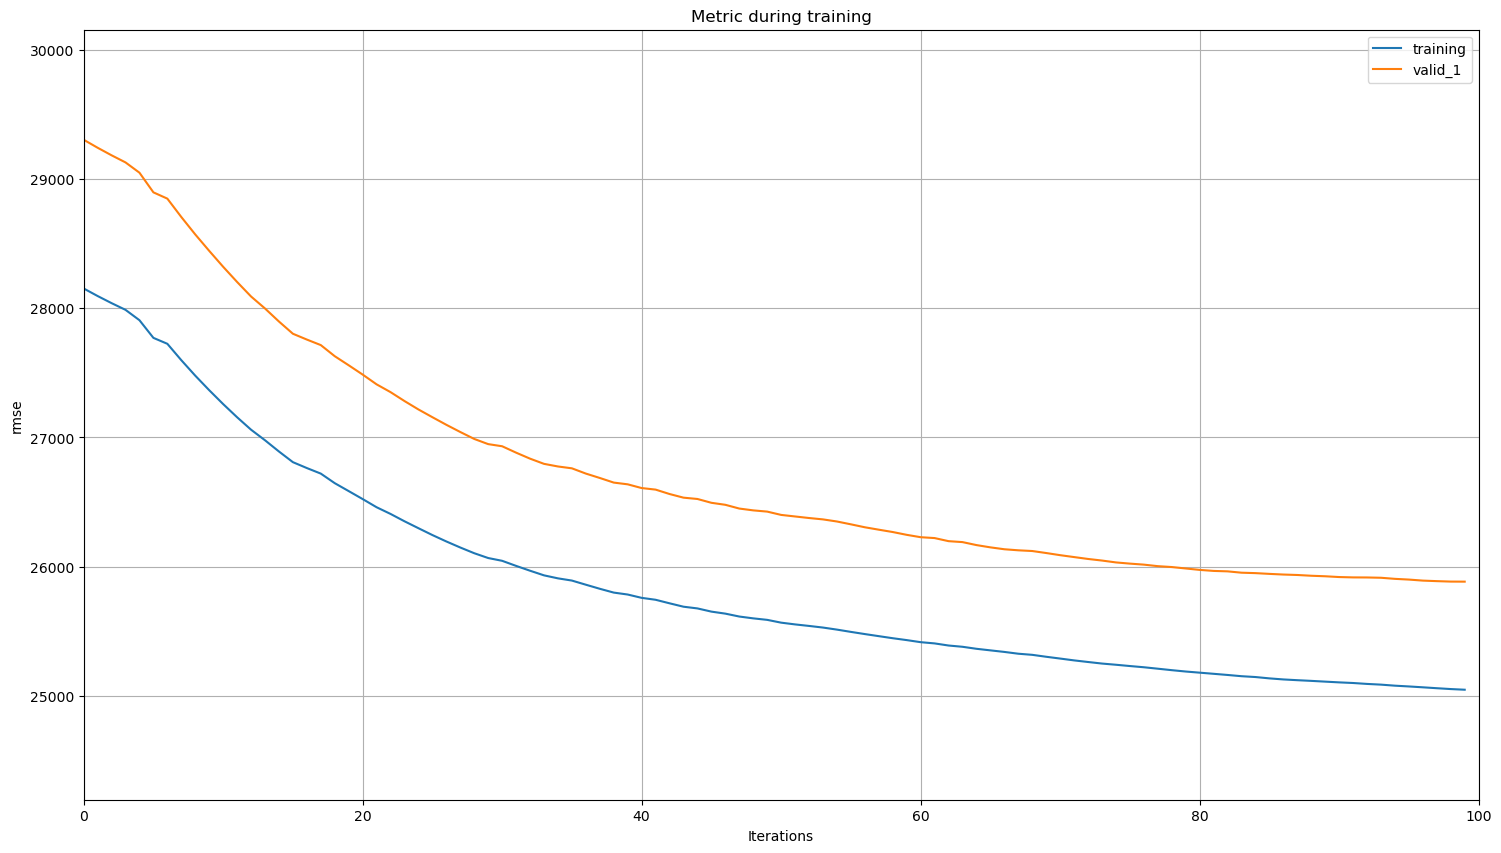

In [283]:
lgbm.plot_metric(model, metric='rmse')

## Predict

In [284]:
# Model Metric
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / (actual+1)))

In [285]:
y_pred = model.predict(x_test)
mean_squared_error(y_test, y_pred) ** 0.5

27040.08971984443

In [286]:
mean_squared_error(y_test, y_pred) ** 0.5

27040.08971984443

## Result

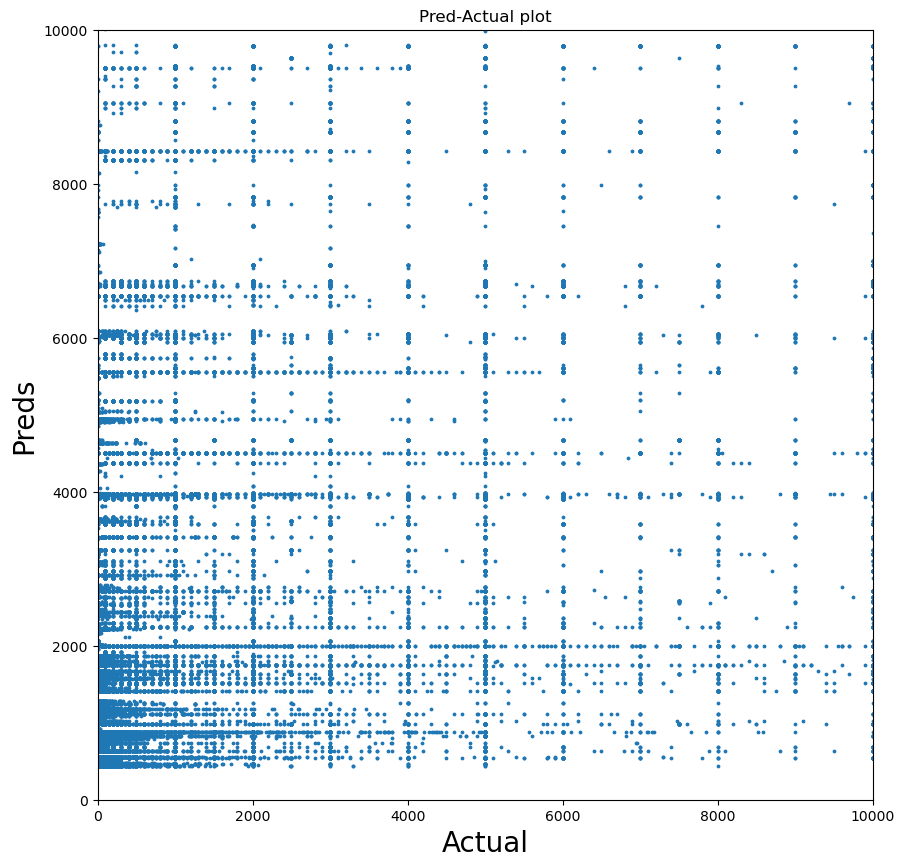

In [288]:
plt.figure(figsize=(10,10))
plt.title("Pred-Actual plot")

plt.scatter(x= y_test,
            y= y_pred,
            s= 3)
plt.xlabel('Actual', fontsize=20)
plt.ylabel('Preds', fontsize=20)
plt.xlim([0,10000])
plt.ylim([0,10000])
plt.show()

In [24]:
df_sum = df.groupby('Date')['Order_Demand'].sum().reset_index()

In [25]:
df_sum = df_sum.set_index('Date')

In [36]:
df_sum

,Order_Demand
Date,
2011-01-08,2
2011-05-31,108
2011-06-24,92000
2011-09-02,1250
2011-09-27,28
...,...
2017-01-03,2400
2017-01-04,29250
2017-01-05,83929


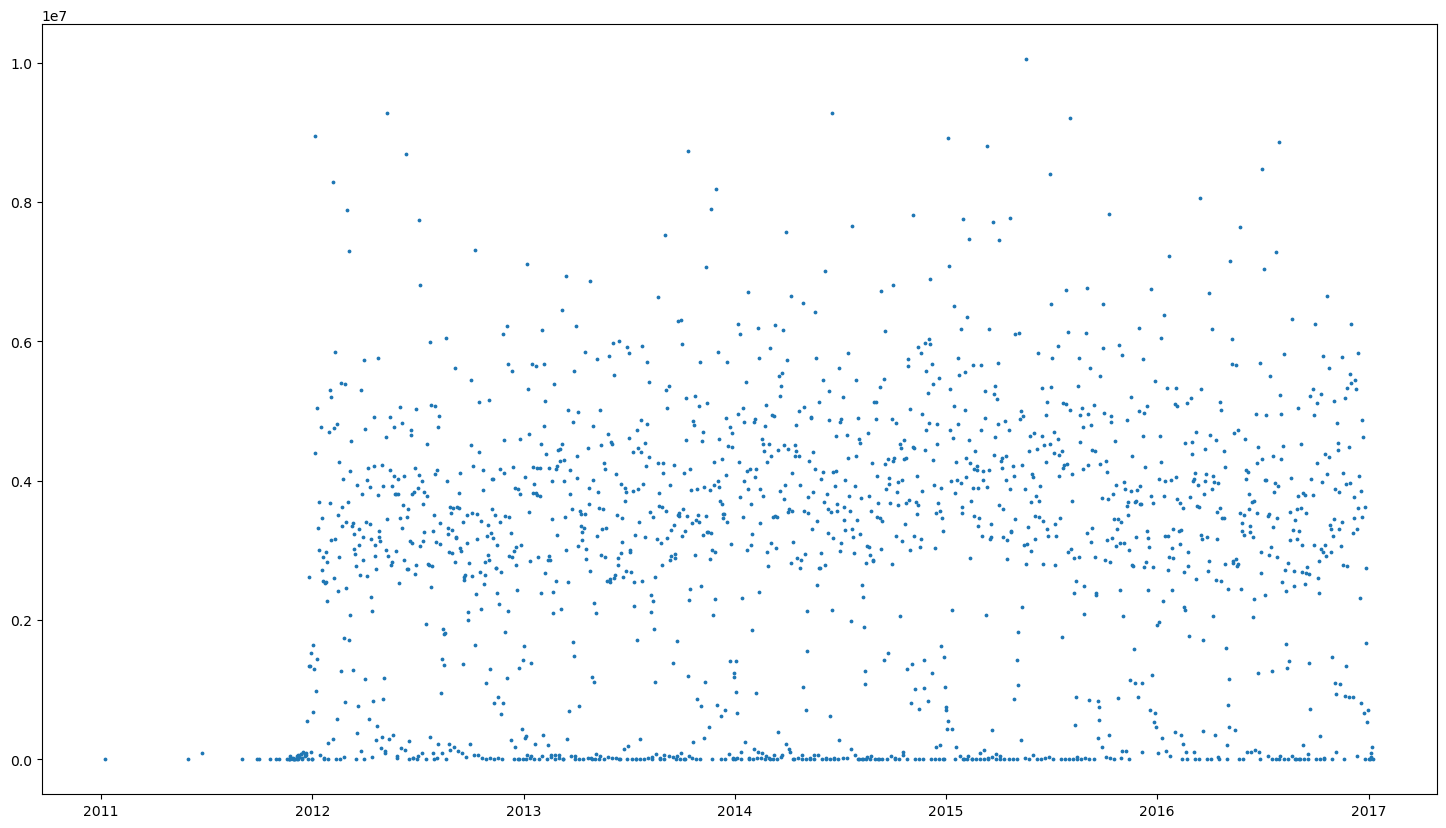

In [197]:
y = df_sum['Order_Demand']
plt.scatter(x=df_sum.index, y=y, s=3)
plt.show()

## Time Series Graph

In [47]:
#Averages daily sales value for the month, 
# and we are using the start of each month as the timestamp.
#y = df_sum['Order_Demand'].resample('MS').mean()

y = df_sum['Order_Demand'].resample('W').mean()

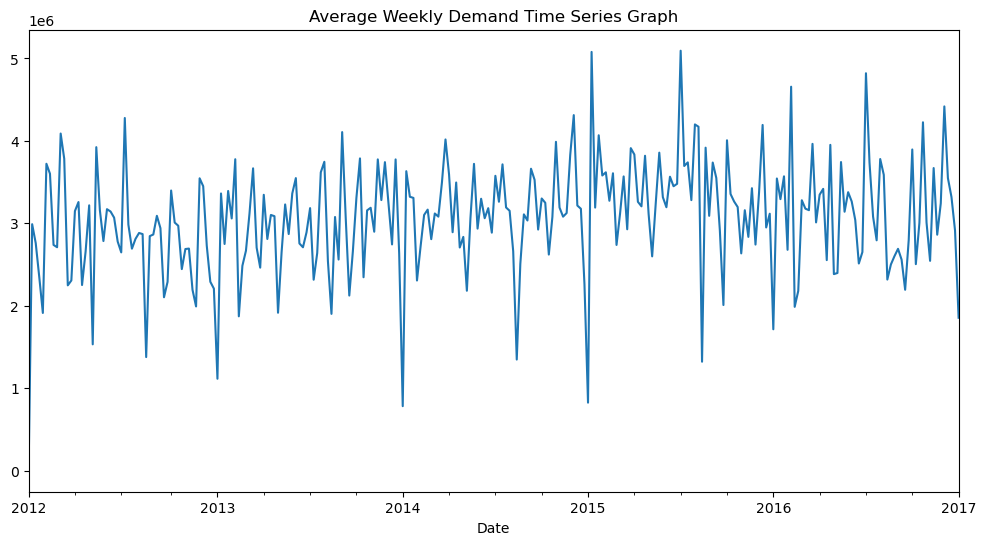

In [96]:
plt.title('Average Weekly Demand Time Series Graph')
y.plot(figsize=(12,6))
plt.show()

## Decomposition

* Additive model : y(t) = Trend + Seasonality + Noise

In [51]:
#The best part about time series data and decomposition is that you can break down the data into the following:
#Time Series Decomposition. 
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 10
decomposition = sm.tsa.seasonal_decompose(y, model='additive', period=10)
fig = decomposition.plot()
plt.show()

ValueError: This function does not handle missing values

In [42]:
type(y)

pandas.core.series.Series

In [81]:
df.groupby('Date').count()

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2011-01-08,1,1,1,1
2011-05-31,1,1,1,1
2011-06-24,2,2,2,2
2011-09-02,1,1,1,1
2011-09-27,2,2,2,2
...,...,...,...,...
2017-01-03,3,3,3,3
2017-01-04,8,8,8,8
2017-01-05,20,20,20,20


### EMD

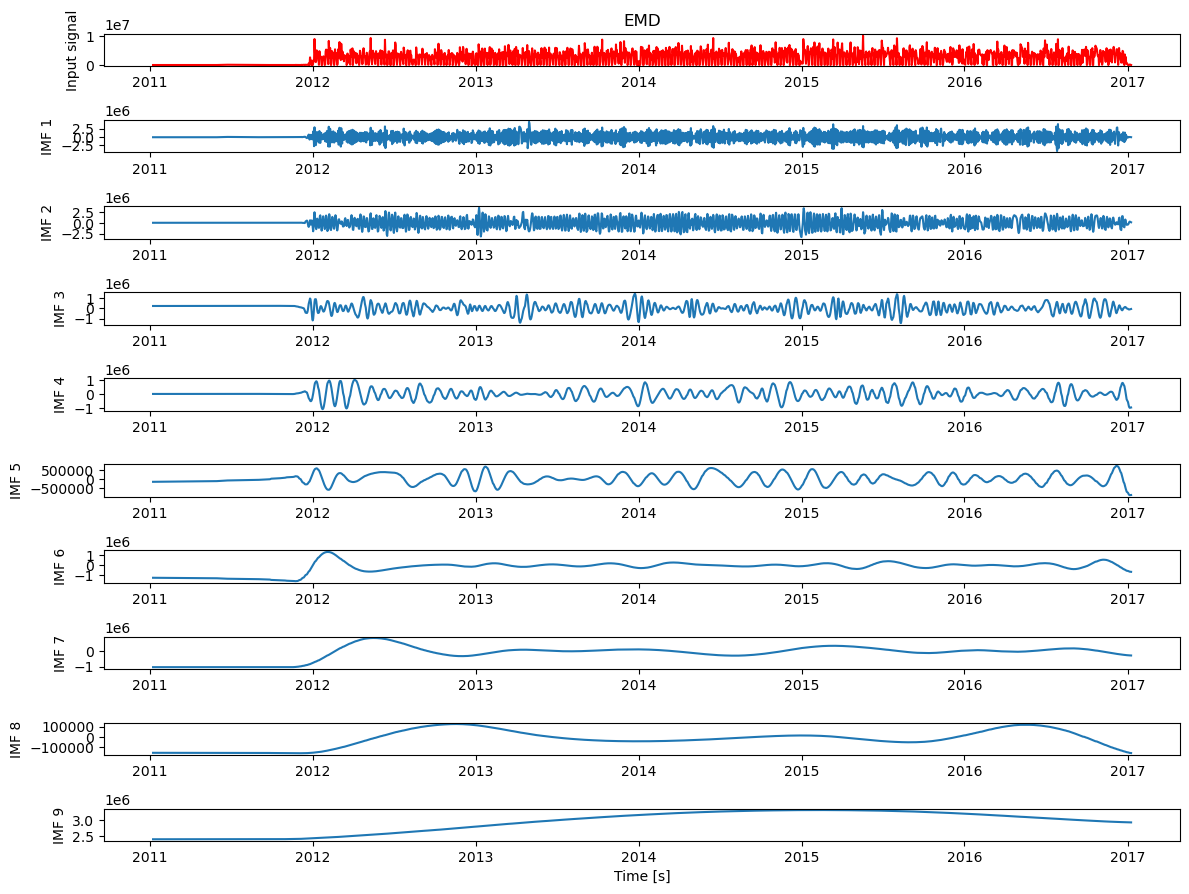

In [56]:
# EMD
from PyEMD import EMD
import numpy  as np
import pylab as plt

# Define signal
t = np.array(y.index)
s = np.array(y)

# Execute EMD on signal
IMF = EMD().emd(s,t)
nIMFs = IMF.shape[0]

# Plot results
plt.figure(figsize=(12,9))
plt.subplot(nIMFs+1, 1, 1)
plt.plot(t, s, 'r')
plt.ylabel("Input signal")
plt.title('EMD')

for n in range(nIMFs):
    plt.subplot(nIMFs+1, 1, n+2)
    plt.plot(t, IMF[n])
    plt.ylabel("IMF %i" %(n+1))
    #plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.tight_layout()
plt.savefig('emd_example', dpi=120)
plt.show()

In [59]:
IMF.shape

(9, 1729)

In [63]:
imfs, residue = .get_imfs_and_residue()
plt.figure(figsize=(12,1.28))
plt.title('Residue')
plt.plot(t, residue ,'g')
plt.show()

TypeError: get_imfs_and_residue() missing 1 required positional argument: 'self'

### EEMD

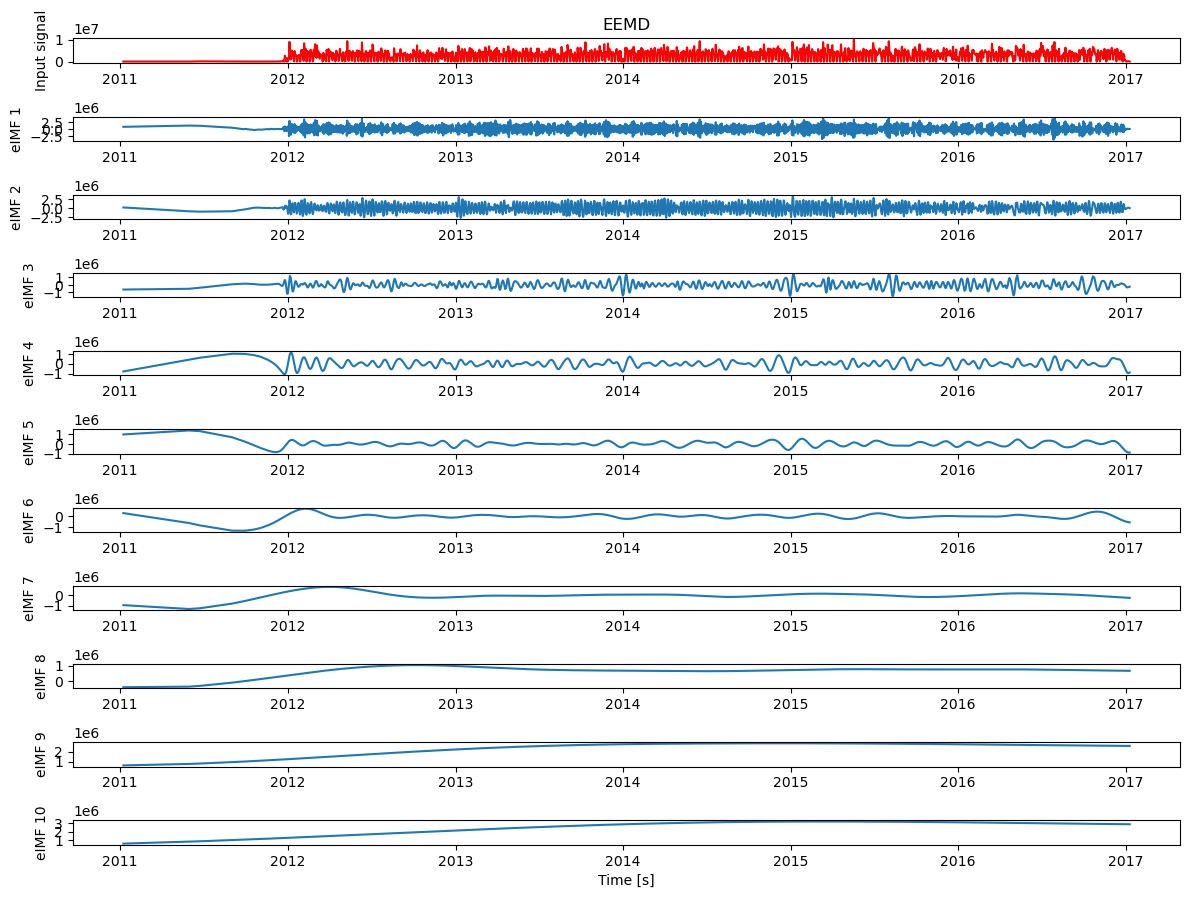

In [60]:
# EEMD
from PyEMD import EEMD
import numpy as np
import pylab as plt

# Define signal
t = np.array(y.index)

s = np.array(y)
# Assign EEMD to `eemd` variable
eemd = EEMD()

# Say we want detect extrema using parabolic method
emd = eemd.EMD
emd.extrema_detection="parabol"

# Execute EEMD on s
eIMFs = eemd.eemd(s, t)
nIMFs = eIMFs.shape[0]

# Plot results
plt.figure(figsize=(12,9))
plt.subplot(nIMFs+1, 1, 1)
plt.title("EEMD")
plt.ylabel("Input signal")
plt.plot(t, s, 'r')

for n in range(nIMFs):
    plt.subplot(nIMFs+1, 1, n+2)
    plt.plot(t, eIMFs[n])
    plt.ylabel("eIMF %i" %(n+1))
    #plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.tight_layout()
plt.savefig('eemd_example', dpi=120)
plt.show()

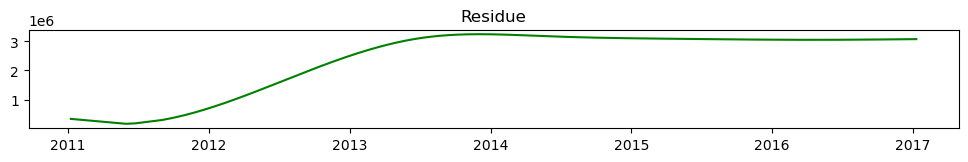

In [65]:
imfs, residue = emd.get_imfs_and_residue()
plt.figure(figsize=(12,1.28))
plt.title('Residue')
plt.plot(t, residue ,'g')
plt.show()

In [67]:
residue.shape

(1729,)